## STEP-1

**Target:**  

Apply regularization to bring overfitting within acceptable range.

**Results:**  
Parameters: 8,512  
Best Train Accuracy: 99.02  
Best Test Accuracy: 98.91 (13th Epoch), 98.66 (15th Epoch)

**Analysis:**  
Droput Regularization(6%) has been added at the end of first and second convolution blocks (randomly), which helped reduce overfitting as expected. The model still needs to learn more efficiently without overfitting and to help the model identify the test images, for which we can try Data Augmentation.

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings 
warnings.filterwarnings('ignore')

# Model Architecture

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Input Block
        self.conv1 = nn.Sequential(nn.Conv2d(1, 4, 3, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU()
        ) #input - RF:1x1; Output RF: 3x3
        
        # Convolution Block-1
        self.conv2 = nn.Sequential(nn.Conv2d(4, 8, 3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU()
        ) #input - RF:3x3; Output RF: 5x5
        
        self.conv3 = nn.Sequential(nn.Conv2d(8, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) #input - RF:5x5; Output RF: 7x7
        
        self.dropout1 = nn.Dropout(0.06)
        
        # Transition Block
        self.maxpool = nn.MaxPool2d(2, 2) #input - RF:7x7; Output RF: 8x8
        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=4, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) #input - RF:8x8; Output RF: 8x8
        
        # Convolution Block-2
        self.conv5 = nn.Sequential(nn.Conv2d(4, 8, 3),
            nn.BatchNorm2d(8),
            nn.ReLU()
        ) #input - RF:8x8; Output RF: 12x12
        
        self.conv6 = nn.Sequential(nn.Conv2d(8, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) #input - RF:12x12; Output RF: 16x16

        self.conv7 = nn.Sequential(nn.Conv2d(16, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ) #input - RF:16x16; Output RF: 20x20
        
        self.dropout2 = nn.Dropout(0.06)

        # GlobalAveragePooling & Output Block
        self.avgpool = nn.AvgPool2d(8) #input - RF:20x20 Output RF: 34x34
        
        self.conv8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) #input - RF:34x34; Output RF: 34x34
        self.conv9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        ) #input - RF:34x34; Output RF: 34x34

        self.dropout = nn.Dropout(0.06)

    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.dropout1(x)
        x = self.maxpool(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.dropout2(x)
        x = self.avgpool(x)
        x = self.conv8(x)
        x = self.conv9(x)        

        x = x.view(-1, 10)

        return F.log_softmax(x)

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
print("Model Summary:")
summary(model, input_size=(1, 28, 28))
print("\n\nModel Architecture:\n\n")
print(model)

Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
       BatchNorm2d-2            [-1, 4, 28, 28]               8
              ReLU-3            [-1, 4, 28, 28]               0
            Conv2d-4            [-1, 8, 28, 28]             296
       BatchNorm2d-5            [-1, 8, 28, 28]              16
              ReLU-6            [-1, 8, 28, 28]               0
            Conv2d-7           [-1, 16, 28, 28]           1,168
       BatchNorm2d-8           [-1, 16, 28, 28]              32
              ReLU-9           [-1, 16, 28, 28]               0
          Dropout-10           [-1, 16, 28, 28]               0
        MaxPool2d-11           [-1, 16, 14, 14]               0
           Conv2d-12            [-1, 4, 14, 14]              64
             ReLU-13            [-1, 4, 14, 14]               0
           Conv2d-14    

Convolution layers: 5 blocks of convolution layers used-  
**1.  1 input layer, with 1 channel input and 4 channels as output**  
**2.  1st Convolution Block: 2 conv layers taking 4 channels as input and expanding to 8 and then 16. Dropout added at the end.**  
**3.  After dropout, a transitional layer with MaxPool and 1x1 convolution used to reduce channel dimensions & count respectively**  
**4.  2nd Convolution Block: 3 conv layers taking 4 channels as input and expanding to 8,16 and 32. Dropout added at the end.**  
**5.  Output block: GAP layer to reduce the channel size from 8 to 1, further connected to two 1x1 conv layers giving 10 outputs.**  

- Batch Normalization used after each convolution layer.  
- Dropout used: 6% at the end first and second convolution blocks.  
- Transition Layer (Max Pool + 1x1 convolution) used after the first dropout, to bring down the channel size and count.  
- Global Average Pooling used to bring down the channel size from 8x8x32 to 1x1x32.  
- Instead of FC layers, 1x1 Fully Connected Convolutions are used after the GAP layer.  
- Total Parameters: 8,512  

# Reading MNIST data

# Data Loader

In [4]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

# Train Function

In [5]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    epoch_loss = 0
    correct = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    print(f'Train set: Average loss: {loss.item():.4f}, Accuracy: {100. * correct/len(train_loader.dataset):.2f}')
    train_loss = epoch_loss / len(train_loader)
    train_acc=100.*correct/len(train_loader.dataset)
    return train_loss, train_acc

# Test Function

In [6]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 100.*correct/len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.3f}, Accuracy: {100. * correct/len(test_loader.dataset):.2f}')
    return test_loss, test_acc

# Defining optimizer and learning rate

In [7]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Running the model

In [8]:
train_loss_values = []
test_loss_values = []

train_acc_values = []
test_acc_values = []

for epoch in range(1, 16):
    print('\nEpoch {} : '.format(epoch))
    # train the model
    train_loss, train_acc = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_acc = test(model, device, test_loader)

    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)

    train_acc_values.append(train_acc)
    test_acc_values.append(test_acc)


Epoch 1 : 
Train set: Average loss: 0.2407, Accuracy: 57.38

Test set: Average loss: 1.927, Accuracy: 46.07

Epoch 2 : 
Train set: Average loss: 0.1238, Accuracy: 94.67

Test set: Average loss: 0.275, Accuracy: 91.36

Epoch 3 : 
Train set: Average loss: 0.0695, Accuracy: 96.89

Test set: Average loss: 0.100, Accuracy: 96.95

Epoch 4 : 
Train set: Average loss: 0.0966, Accuracy: 97.59

Test set: Average loss: 0.078, Accuracy: 97.62

Epoch 5 : 
Train set: Average loss: 0.0738, Accuracy: 97.95

Test set: Average loss: 0.085, Accuracy: 97.49

Epoch 6 : 
Train set: Average loss: 0.0420, Accuracy: 98.17

Test set: Average loss: 0.066, Accuracy: 98.14

Epoch 7 : 
Train set: Average loss: 0.0706, Accuracy: 98.37

Test set: Average loss: 0.070, Accuracy: 98.07

Epoch 8 : 
Train set: Average loss: 0.0108, Accuracy: 98.52

Test set: Average loss: 0.103, Accuracy: 96.84

Epoch 9 : 
Train set: Average loss: 0.0701, Accuracy: 98.63

Test set: Average loss: 0.047, Accuracy: 98.65

Epoch 10 : 
Train 

# Plotting the train and test loss across each epoch

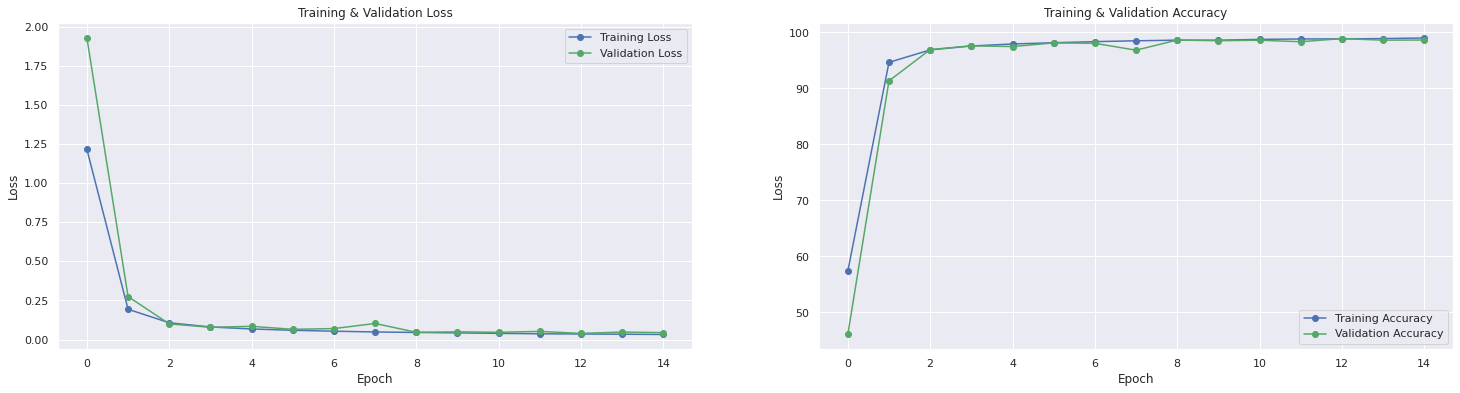

In [9]:
# Use plot styling from seaborn.
sns.set(style='whitegrid')

# Increase the plot size and font size.
sns.set(font_scale=1)
plt.rcParams["figure.figsize"] = (25,6)

# Plot the learning curve.
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(np.array(train_loss_values), 'b-o', label="Training Loss")
ax1.plot(np.array(test_loss_values), 'g-o', label="Validation Loss")

# Label the plot.
ax1.set_title("Training & Validation Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(np.array(train_acc_values), 'b-o', label="Training Accuracy")
ax2.plot(np.array(test_acc_values), 'g-o', label="Validation Accuracy")

# Label the plot.
ax2.set_title("Training & Validation Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.legend()

plt.show()

# Average Validation Loss

In [10]:
print(f'Average Validation loss: {test_loss:.3f}')

Average Validation loss: 0.045
